In [1]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import pylab
import json
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

def query2df(conn, query):
    return pd.read_sql_query(query,conn)

def parse_loc(loc_str):
    l = json.loads(loc_str)
    loc_type = l["$type"].replace("edu.colorado.plv.bounder.ir.","")
    if loc_type == "AppLoc":
        return [loc_type]
    if loc_type.startswith("InternalMethod"):
        return [loc_type,l["clazz"],l["name"]]
    if loc_type.startswith("CallbackMethod"):
        return [loc_type,l["fmwClazz"],l["fmwName"]]
    if loc_type.startswith("GroupedCallinMethod"):
        return [loc_type,l['targetClasses'],l['fmwName']]
    raise Exception("bad loc: %s" % loc_str)

def loc_at_id(conn,node_id):
    d = pd.read_sql_query(con = conn, sql = "SELECT NODE_LOC FROM PATH WHERE NODE_ID=?;", params=[int(node_id)])
    return parse_loc(d['NODE_LOC'][0])


    
    
def pred(conn,node_id):
    d = pd.read_sql_query(con = conn, sql = "SELECT PRED from PATH where NODE_ID=?",params=[node_id])
    return d['PRED'][0]

def get_method(conn,class_like,method_like):
    d = pd.read_sql_query(con = conn, 
                         sql = "SELECT * from Methods where DECLARING_CLASS like ? and NAME like ? order by DECLARING_CLASS;",
                         params = [class_like, method_like])
    return d

def get_call_edges(conn,class_name,method_name):
    d = pd.read_sql_query(con = conn,
                         sql = "select TGT_NAME,TGT_CLASS from CALL_EDGES where SRC_NAME=? and SRC_CLASS=?",
                         params = [method_name,class_name])
    return d
def find_mega_call_edge(conn,class_name,method_name):
    edges = get_call_edges(conn,class_name,method_name)
    #TODO
def display_call_edges(conn,class_name,method_name):
    edges = get_call_edges(conn,class_name,method_name)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, "max_colwidth", None):
        display(edges)

def display_no_limit(v):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, "max_colwidth", None):
        display(v)
def highlight_text(in_str, replace_strs):
#     colored = "\x1b[31m %s \x1b[0m" % replace_str
    out = in_str
    for replace_str in replace_strs:
        colored = "\x1b[32m %s \x1b[0m" % replace_str
        out = out.replace(replace_str,colored)
    return out
def shorten_body(body):
    return body.replace("java.lang","_jl")\
        .replace("de.danoeh.antennapod.core.util.playback","_apcu").replace("de.danoeh.antennapod.core.util","_apcu").replace("de.danoeh.antennapod.core.service.playback","_apcsp").replace("de.danoeh.antennapod.core.service","_apcs").replace("de.danoeh.antennapod","_ap").replace("de.danoeh.antennapod.core","_apc")

def highlight_methods_containing(conn,clazz,value):
    pcMethods =get_method(conn,"%" + clazz + "%","%%")
    clazz = ""
    for v1,v2 in pcMethods.T.iteritems():
        if(value in v2['BODY']):
            if(v2['DECLARING_CLASS'] != clazz):
                clazz = v2['DECLARING_CLASS']
                print("\n\n\n")
                print(clazz)
                print("==========")
            print("")
            print("name: %s" % v2['NAME'])
            print("---")
            short_b = shorten_body(v2['BODY'])
            print(highlight_text(short_b,value))
def count_queries_at_depth(conn, depth):
    d = pd.read_sql_query(con = conn,
                           sql = 'select count(*) as count from PATH where DEPTH = ?;',
                           params = [depth])
    return d['count'][0]

def queries_at_depth(conn, depth):
    d = pd.read_sql_query(con = conn,
                           sql = 'select NODE_ID from PATH where DEPTH = ?;',
                           params = [depth])
    return d['NODE_ID']

def random_nodes(conn,count):
    d = pd.read_sql_query(con=conn,
                         sql = "select NODE_ID from PATH order by random() limit ?;", params=[count])
    return d['NODE_ID']


/Users/shawnmeier/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
deepconn = create_connection("/Users/shawnmeier/Desktop/bounder_debug_data/deref2_deepSubsume.db")
fastconn = create_connection("/Users/shawnmeier/Desktop/bounder_debug_data/deref2_fastSubsume.db")

In [ ]:
xv = range(50)
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot(xv, [count_queries_at_depth(deepconn,v) for v in xv], label='deep')
ax.plot(xv, [count_queries_at_depth(fastconn,v) for v in xv], label='fast')
plt.legend()

Compare disjunctions vs depth for implementation

In [46]:
conn_older = create_connection("/Users/shawnmeier/Desktop/bounder_debug_data/paths_antennapod2.db")
conn_old = create_connection("/Users/shawnmeier/Desktop/bounder_debug_data/paths_antennapod3.db")
conn_ap_current = create_connection("/Users/shawnmeier/Desktop/bounder_debug_data/paths.db")

max new 87
max old 299


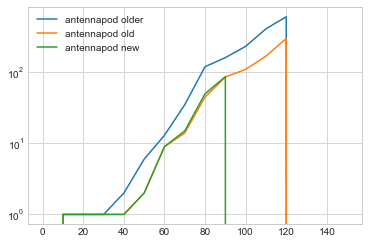

In [47]:
xv = [v* 10 for v in range(16)]
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
yvo = [count_queries_at_depth(conn_older,v) for v in xv]
yv = [count_queries_at_depth(conn_old,v) for v in xv]
yvs = [count_queries_at_depth(conn_ap_current,v) for v in xv]
ax.plot(xv, yvo, label='antennapod older')
ax.plot(xv, yv, label='antennapod old')
ax.plot(xv,yvs,label='antennapod new')
plt.yscale("log")
plt.legend()
print("max new %i" % max(yvs))
print("max old %i" % max(yv))

In [11]:
conn = conn_ap_current
def selectNonSkippedMethods(conn):
    #TGT - node that is later in control flow
    #SRC - node earlier in control flow
    tgtIsIntRet = 'and TGT.NODE_LOC like "%InternalMethodReturn%" '
    srcIsAppLoc = 'and SRC.NODE_LOC like ' + \
        '"%colorado.plv.bounder.ir.AppLoc%"'
    qry = 'SELECT count(SRC.NODE_ID) as count, TGT.NODE_LOC as method '+\
        'from PATH TGT, PATH SRC ' + \
        ' where SRC.NODE_ID <> TGT.NODE_ID and SRC.PRED = TGT.NODE_ID '+ \
        tgtIsIntRet + \
        srcIsAppLoc + \
        ' group by TGT.NODE_LOC order by count(SRC.NODE_ID) desc;'
#         (' limit 10;' % limit if limit is not None else '')
    edges = pd.read_sql_query(con = conn,
                sql = qry)
    return edges

def count_internal_call_edges(conn, clazz, name):
    edges = get_call_edges(conn, clazz, name)
    contains = edges['TGT_CLASS'].apply(lambda x: 'de.danoeh' in x)
    edges = edges[contains]
    
    return len(edges.index)
nonSkipped = selectNonSkippedMethods(conn)
mn = lambda x: parse_loc(x)[2]
mc = lambda x: parse_loc(x)[1]
nonSkipped['method_name'] = nonSkipped['method'].apply(mn)
nonSkipped['method_class'] = nonSkipped['method'].apply(mc)
nonSkipped['call_count'] = nonSkipped.apply(
        lambda row: count_internal_call_edges(conn,row['method_class'],row['method_name']),
        axis = 1
    )
nonSkipped = nonSkipped.drop(columns=['method'])
nonSkipped['comb'] = nonSkipped['count']*nonSkipped['call_count']
#'count','call_count' excluded
nonSkipped = nonSkipped[['count','comb','method_name','method_class']]
nonSkipped = nonSkipped.sort_values(by='comb',ascending=False)
display_no_limit(nonSkipped)
# plt.barh("method_name",'count',data=nonSkipped)

,count,comb,method_name,method_class
1,75,450,boolean loadMediaInfo(),de.danoeh.antennapod.activity.MediaplayerActivity
0,75,150,void updatePlaybackSpeedButton(),de.danoeh.antennapod.activity.AudioplayerActivity
2,36,108,int getPosition(),de.danoeh.antennapod.core.util.playback.PlaybackController
4,24,96,void onPositionObserverUpdate(),de.danoeh.antennapod.activity.MediaplayerActivity
18,9,72,void updateUi(de.danoeh.antennapod.core.util.playback.Playable),de.danoeh.antennapod.fragment.ExternalPlayerFragment
11,12,72,boolean loadMediaInfo(),de.danoeh.antennapod.activity.VideoplayerActivity
6,18,54,int getDuration(),de.danoeh.antennapod.core.util.playback.PlaybackController
12,12,48,int getPosition(),de.danoeh.antennapod.core.service.playback.LocalPSMP
5,20,40,boolean loadMediaInfo(),de.danoeh.antennapod.fragment.ExternalPlayerFragment
10,12,36,boolean loadMediaInfo(),de.danoeh.antennapod.activity.MediaplayerInfoActivity


<BarContainer object of 20 artists>

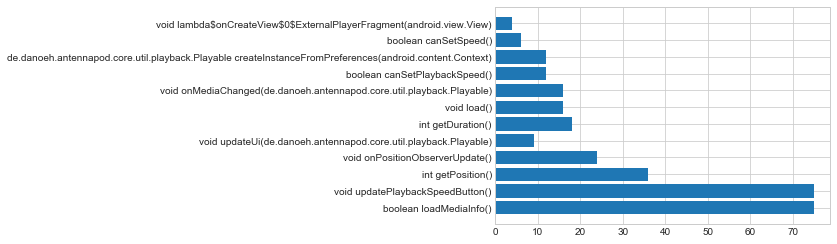

In [12]:
plt.barh('method_name','count', data=nonSkipped.head(20))

In [14]:
for v in queries_at_depth(conn, 2):
    print(v)
    print(loc_at_id(conn,v))
    print(pred(conn,v))
    print('---')
    

52595
['GroupedCallinMethodReturn', ['android.support.v4.app.Fragment'], 'android.support.v4.app.FragmentActivity getActivity()']
52594
---
52596
['GroupedCallinMethodReturn', ['android.support.v4.app.Fragment'], 'android.support.v4.app.FragmentActivity getActivity()']
52594
---


In [15]:
from flame_analyzer.utils import generate_flame_graph_html, format_options
from IPython.core import display
import flame_analyzer.hooks as hooks
import copy
class CallStackSample:
    """
    Stores a collection of function call stacks.
    """
    def __init__(self):
        self.stacks = []
        self.common_fn_calls = []

    def add_stack(self, stack):
        self.stacks.append(stack)
        self.measure_common_fn_calls(stack)

    def trimmed_stacks(self):
        """
        Return stacks filtering out elements common to the root of all stacks.
        """
        return [
            stack[self.highest_common_fn_call_index():]
            for stack in self.stacks
        ]

    def highest_common_fn_call_index(self):
        return len(self.common_fn_calls)

    def measure_common_fn_calls(self, new_stack):
        # First iteration, nothing to compare.
        if not self.common_fn_calls:
            self.common_fn_calls = copy.deepcopy(new_stack)
            return

        # Cut the common stack to the depth of the shortest stack, there
        # can't be common function calls where one stack is deeper than the
        # other.
        min_stack_depth = min(len(new_stack), len(self.common_fn_calls))
        self.common_fn_calls = self.common_fn_calls[:min_stack_depth]

        # Compare each existing function call in the common stack with its
        # match in the new stack to find the deepest common function call.
        common_stack_depth = 0
        for a, b in zip(self.common_fn_calls, new_stack):
            if a == b:
                common_stack_depth += 1

        # Throw away non common function calls.
        self.common_fn_calls = self.common_fn_calls[:common_stack_depth]
class FunctionCall:
    """
    Data container for a function call in the stack.
    """
    def __init__(self, name, path):
        self.name = name
        self.path = path

    def __eq__(self, other):
        if isinstance(other, FunctionCall):
            return self.name == other.name and self.path == other.path
        return False

    def __str__(self):
        return '{}({})'.format(self.name, self.path)

    def __repr__(self):
        return str(self)

def flame_to_step(conn, depth):
    atD = queries_at_depth(conn, depth)
    samples = [[[],q] for q in atD]
    sample = CallStackSample()
    total = len(samples)
    cur = 0
    for s in samples:
        if(cur%10 == 0):
            print("%i / %i" % (cur,total))
        while(s[1] is not None):
            loc = loc_at_id(conn,int(s[1]))
            if(loc[0] != "AppLoc"):
                clazz = loc[1][0] if isinstance(loc[1],list) else loc[1]
                s[0].insert(0,FunctionCall(loc[0] + ":" + loc[2],clazz))
            s[1] = pred(conn,int(s[1]))
        s[0].insert(0,FunctionCall("dummy","dummy"))
        sample.add_stack(s[0])
        cur += 1

    opt = {'width':8000,'title':'Traces',
           'fontsize':12,
           'subtitle':'','countname':'Samples'}
    html = generate_flame_graph_html(sample, format_options(opt))

    display.display(display.SVG(data=html))

class State:
    def __init__(self,full):
        self.full = full
        self.l = json.loads(full)
#         self.callStack = [FunctionCall(v['methodLoc']['name'],v['clazz']) for v in self.l["callStack"]]
        self.callStack = [sf['methodLoc'] for sf in self.l['callStack']]
    def get_call_stack(self):
        out = []
        for js_stack_frame in self.l['callStack']:
            method_loc = js_stack_frame['methodLoc']
#             print("---")
#             print(js_stack_frame)
            if 'name' in method_loc:
                function_call = FunctionCall(method_loc['name'], method_loc['clazz'])
            elif 'targetClasses' in method_loc:
                function_call = FunctionCall(method_loc['fmwName'], method_loc['targetClasses'][0])
            else:
                function_call = FunctionCall(method_loc['fmwName'], method_loc['fmwClazz'])
            out.append(function_call)
#         out.reverse
        return out


def state_at_id(conn,node_id):
    d = pd.read_sql_query(con=conn, sql= "SELECT NODE_STATE FROM PATH WHERE NODE_ID=?;",params=[int(node_id)])
    return State(d['NODE_STATE'][0])



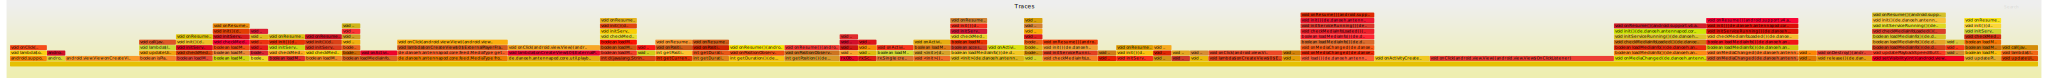

In [16]:
# state_at_id(conn2,random_nodes(conn2,1)[0]).get_call_stack()
# state_samples = random_nodes(conn2, 500)
state_samples = queries_at_depth(conn, 100)
sample = CallStackSample()
for state_sample in state_samples:
    state = state_at_id(conn, state_sample)
    cs = state.get_call_stack()
    cs.insert(0,FunctionCall("dummy","dummy"))
    sample.add_stack(cs)
opt = {'width':6000,'title':'Traces',
           'fontsize':12,
           'subtitle':'','countname':'Samples'}
html = generate_flame_graph_html(sample, format_options(opt))
display.display(display.SVG(data=html))

In [ ]:
bodies = get_method(conn,"%de.danoeh.antennapod.fragment.ExternalPlayerFragment%","%void lambda$onCreateView$0$ExternalPlayerFragment(android.view.Vie%")['BODY']
for b in bodies:
    print(shorten_body(highlight_text(b,["arg$1","subscription","controller"])))

In [ ]:
flame_to_step(conn2, 80)

In [ ]:
# Highlight methods containing
highlight_methods_containing(conn,"playback.PlaybackController","arg$1")



In [ ]:
display_call_edges(conn, "de.danoeh.antennapod.core.util.playback.PlaybackController","void checkMediaInfoLoaded()")


In [ ]:
bodies = get_method(conn,"%util.playback.PlaybackController%","%void checkMediaInfoLoaded()%")['BODY']
for b in bodies:
    print(shorten_body(highlight_text(b,["arg$1","subscription","controller"])))

Experiment: how much fanout results from call graph imprecision?

In [ ]:
## Most commony visited internal methods
callLocs = pd.read_sql_query(con = conn2,
        sql = 'select count(NODE_ID),NODE_LOC from PATH ' +
                 'where NODE_LOC like "%InternalMethod%" ' +
                 'group by NODE_LOC order by count(NODE_ID) desc;')
locOp = lambda x:shorten_body(str(parse_loc(x)))
typeOp = lambda x:parse_loc(x)[0]
classOp = lambda x:parse_loc(x)[1]
callLocs['NODE_LOC'] = callLocs['NODE_LOC'].apply(typeOp)
callLocs['Class'] = callLocs['NODE_LOC'].apply(classOp)
display_no_limit(callLocs)

In [ ]:
## Visited internal methods that aren't skipped

In [ ]:
## Do we hit any recursive methods?
## - no, keep this around for now

## Directly recursive methods TODO: doesn't include mutually recursive
dRec = pd.read_sql_query(con = conn,
                        sql = 'select * from CALL_EDGES where SRC_NAME = TGT_NAME and SRC_CLASS == TGT_CLASS')
recMethods = []
for ind,row in dRec.iterrows():
    recMethods.append(("%" + row['SRC_NAME'] + "%",
                       "%" + row['SRC_CLASS'] + "%"))

outR = None
count = 0
for rm in recMethods:
    count = count+1
    print(count)
    cdf = pd.read_sql_query(con=conn,
                    sql="SELECT distinct NODE_LOC from PATH where NODE_LOC like ? and NODE_LOC like ?;",
                    params = [rm[0],rm[1]])
    print("rows: %i" % len(cdf.index))
    if outR == None:
        outR == cdf
    else:
        outR.append(cdf)

In [ ]:
def selectNonSkippedMethods(conn):
    #TGT - node that is later in control flow
    #SRC - node earlier in control flow
    tgtIsIntRet = 'and TGT.NODE_LOC like "%InternalMethodReturn%" '
    srcIsAppLoc = 'and SRC.NODE_LOC like ' + \
        '"%colorado.plv.bounder.ir.AppLoc%"'
    qry = 'SELECT count(SRC.NODE_ID) as count, TGT.NODE_LOC as method '+\
        'from PATH TGT, PATH SRC ' + \
        ' where SRC.NODE_ID <> TGT.NODE_ID and SRC.PRED = TGT.NODE_ID '+ \
        tgtIsIntRet + \
        srcIsAppLoc + \
        ' group by TGT.NODE_LOC order by count(SRC.NODE_ID) desc;'
#         (' limit 10;' % limit if limit is not None else '')
    edges = pd.read_sql_query(con = conn,
                sql = qry)
    return edges

def count_internal_call_edges(conn, clazz, name):
    edges = get_call_edges(conn, clazz, name)
    contains = edges['TGT_CLASS'].apply(lambda x: 'de.danoeh' in x)
    edges = edges[contains]
    
    return len(edges.index)
nonSkipped = selectNonSkippedMethods(conn2)
mn = lambda x: parse_loc(x)[2]
mc = lambda x: parse_loc(x)[1]
nonSkipped['method_name'] = nonSkipped['method'].apply(mn)
nonSkipped['method_class'] = nonSkipped['method'].apply(mc)
nonSkipped['call_count'] = nonSkipped.apply(
        lambda row: count_internal_call_edges(conn2,row['method_class'],row['method_name']),
        axis = 1
    )
nonSkipped = nonSkipped.drop(columns=['method'])
nonSkipped['comb'] = nonSkipped['count']*nonSkipped['call_count']
#'count','call_count' excluded
nonSkipped = nonSkipped[['comb','method_name','method_class']]
nonSkipped = nonSkipped.sort_values(by='comb',ascending=False)
display_no_limit(nonSkipped)

In [ ]:
get_call_edges(conn, "de.danoeh.antennapod.core.storage.DBReader", "de.danoeh.antennapod.core.feed.FeedItem getFeedItem(long,de.danoeh.antennapod.core.storage.PodDBAdapter)")